In [1]:
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")


2024-12-11 19:30:18.176627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 19:30:18.210171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 19:30:18.219332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 19:30:18.332250: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1733956223.362310    6366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733956223.693756    6366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733956223.694006    6366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
train_dataset = image_dataset_from_directory(
    "data/train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "data/val",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "data/test",
    image_size=(180, 180),
    batch_size=32)

Found 8819 files belonging to 15 classes.


I0000 00:00:1733956224.277291    6366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733956224.277670    6366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733956224.277850    6366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733956224.390099    6366 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 1891 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.


## Balanceo de clases

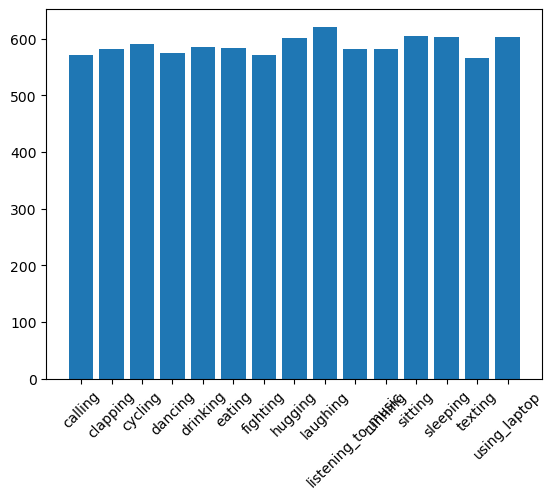

In [4]:
# Obtener las clases
classes = train_dataset.class_names

# Contar las imágenes por clase
count = {}
for c in classes:
    count[c] = len(os.listdir(f"data/train/{c}"))
    
# Graficar
plt.bar(count.keys(), count.values())
plt.xticks(rotation=45)
plt.show()

In [5]:
# Convertir a escala de grises
train_dataset_gray = train_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
validation_dataset_gray = validation_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

In [6]:
# Verificar la forma de las imágenes
for images, labels in train_dataset_gray.take(1):
    print(f"Forma de las imágenes en escala de grises: {images.shape}")

Forma de las imágenes en escala de grises: (32, 180, 180, 1)


2024-12-11 19:30:26.796084: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2024-12-11 19:30:29.162885: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


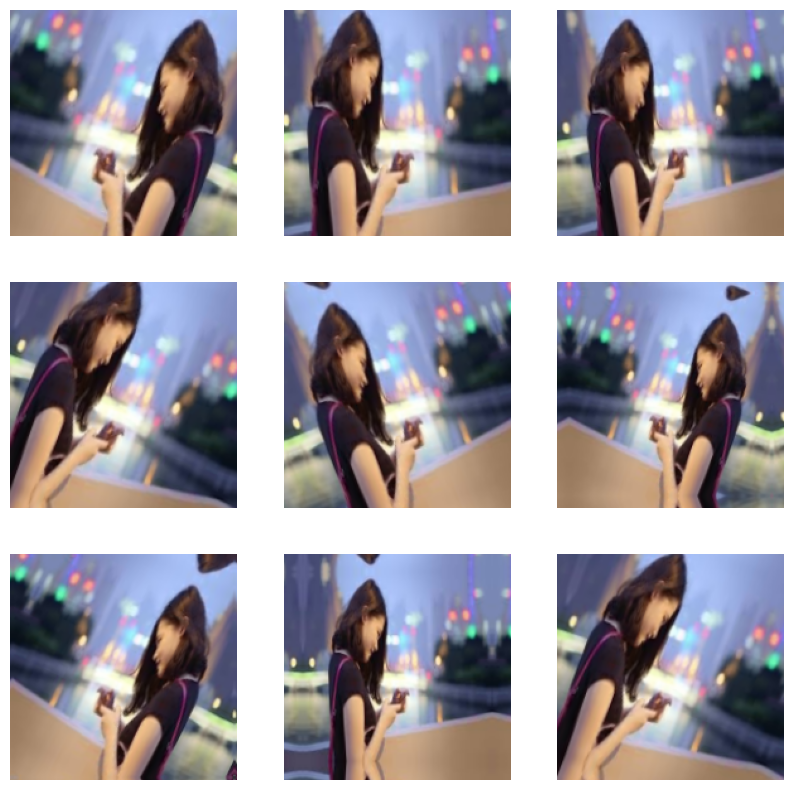

In [8]:
# Muestra imágenes con y sin aumento de datos
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
inputs = keras.Input(shape=(180, 180, 3))  
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Bloque 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Bloque 2
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Bloque 3
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Bloque 4
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Bloque 5
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)  # Dropout fuerte en la parte densa (50%)

# Capa de salida
outputs = layers.Dense(15, activation="softmax")(x)

# Definir el modelo
model = keras.Model(inputs=inputs, outputs=outputs)


In [10]:
# Compilar el modelo
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │       188,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,166,671 (4.45 MB)

 Trainable params: 1,166,671 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Entrenar el modelo
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

warnings.filterwarnings("ignore", message=".*Skipping the delay kernel, measurement accuracy will be reduced.*")


Epoch 1/100


2024-12-11 19:30:32.985447: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90100
W0000 00:00:1733956233.342276    6410 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956233.409759    6410 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956233.413601    6410 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956233.432579    6410 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956233.436090    6410 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956233.439601    6410 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956233.452417    6410 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956233.456065    6410 gpu_

275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.0700 - loss: 2.7094

W0000 00:00:1733956298.061817    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.070437    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.079013    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.086898    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.095889    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.105393    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.113949    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.122771    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956298.131955    6412 gp

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.0701 - loss: 2.7093

W0000 00:00:1733956301.617738    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.635981    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.645704    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.662308    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.676693    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.691187    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.705680    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.713333    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956301.731165    6411 gp

276/276 ━━━━━━━━━━━━━━━━━━━━ 74s 233ms/step - accuracy: 0.0701 - loss: 2.7092 - val_accuracy: 0.0999 - val_loss: 2.6245
Epoch 2/100


W0000 00:00:1733956303.502245    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956303.503980    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956303.505563    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956303.507259    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956303.509106    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733956303.515940    6411 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.1137 - loss: 2.6119 - val_accuracy: 0.1396 - val_loss: 2.6594
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.1558 - loss: 2.5360 - val_accuracy: 0.1888 - val_loss: 2.4363
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.1906 - loss: 2.4586 - val_accuracy: 0.2099 - val_loss: 2.3695
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.2284 - loss: 2.3605 - val_accuracy: 0.2158 - val_loss: 2.3714
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.2385 - loss: 2.3171 - val_accuracy: 0.2977 - val_loss: 2.1468
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.2681 - loss: 2.2304 - val_accuracy: 0.2956 - val_loss: 2.1455
Epoch 8/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.2821 - loss: 2.1823 - val_accuracy: 0.3030 - val_loss: 2.1166
Epoch 9/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.3097 - loss: 2.1266 - val_

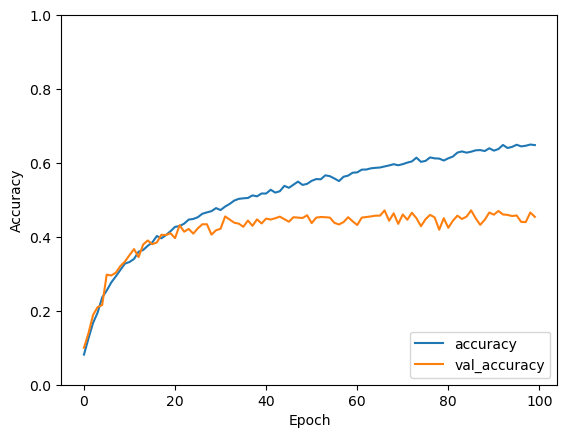

In [13]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4601 - loss: 2.2065

W0000 00:00:1733958830.990722    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958830.992158    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958830.993491    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958830.995064    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958830.996574    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958830.997975    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958830.999417    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958831.000838    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733958831.002271    6412 gp

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4603 - loss: 2.2080
Test loss: 2.2388718128204346
Test accuracy: 0.46296295523643494


W0000 00:00:1733958831.196870    6412 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


In [15]:
# Guardar el modelo
#model.save("/home/luciano/Documentos/Facultad/4to/2_semestre/Inteligencia_Artificial_2/ia2-uncuyo-2024/human-action-recognition/humanActionRecognition/models/model02.keras")